In [11]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Embedding, SpatialDropout1D, Bidirectional, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.layers import GRU, LSTM, concatenate, BatchNormalization, Dropout, Dense
from keras import Model, optimizers
from keras.optimizers import Adam
from keras.models import load_model
from livelossplot import PlotLossesKeras

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
embedding_path = "glove.840B.300d.txt"

embed_size = 300

In [4]:
# get word embeddings from Global Vectors 

def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

embedding_index = dict(get_coefs(*o.split(" ")) for o in open(embedding_path, encoding='utf-8', errors='ignore'))
all_embs = np.stack(embedding_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()

In [5]:
emb_mean

-0.005838499

In [6]:
max_features = 90000
tk = Tokenizer(lower = False, filters='', num_words=max_features)
full_text = list(train['question_text'].values) + list(test['question_text'].values)
tk.fit_on_texts(full_text)

In [7]:
word_index = tk.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words + 1, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [16]:
print(embedding_matrix)

[[ 0.24383887 -0.02290814  0.99608298 ... -0.19394537 -0.22373651
  -0.19423898]
 [ 0.27204001 -0.06203    -0.1884     ...  0.13015001 -0.18317001
   0.1323    ]
 [-0.20627999  0.36715999 -0.071933   ...  0.14271     0.50059003
   0.038025  ]
 ...
 [-0.34430999  0.15748    -0.42466    ...  0.10343    -0.10703
   0.21273001]
 [ 0.22016834 -0.66039357  0.12922829 ...  0.2157204  -0.21941766
   0.49460736]
 [ 0.65435286 -0.39300313  0.58677278 ... -0.71829137 -0.41043048
  -0.15604522]]


In [17]:
max_len = 70
train_tokenized = tk.texts_to_sequences(train['question_text'].fillna('missing'))
test_tokenized = tk.texts_to_sequences(test['question_text'].fillna('missing'))
X = pad_sequences(train_tokenized, maxlen = max_len)

In [18]:
ohe = OneHotEncoder(sparse=False)
Y = ohe.fit_transform(train['target'].values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(875101, 70) (875101, 2)
(431021, 70) (431021, 2)


In [19]:
#Single Bidrectional LSTM, Single BatchNormaization, Double Dense

def build_model1(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, 
                conv_size=32, epochs=20):
    file_path = "best_model.hdf5"
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)

    inp = Input(shape = (max_len,))
    x = Embedding(max_features + 1, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_lstm = Bidirectional(LSTM(units, return_sequences = True))(x1)
    
    
    x_conv2 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    max_pool1_lstm = GlobalMaxPooling1D()(x_conv2)

    
    
    x = max_pool1_lstm
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dense(2, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    model.summary()
    history = model.fit(X_train, y_train, batch_size = 512, epochs = epochs, validation_split=0.1, 
                        verbose = 1, callbacks = [check_point, early_stop, PlotLossesKeras()])
    model = load_model(file_path)
    return model


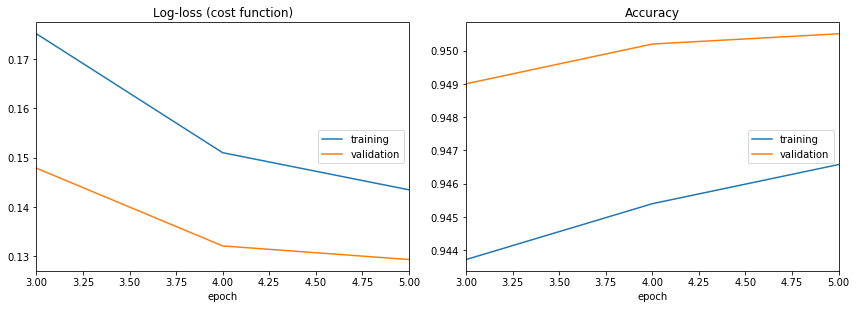

Log-loss (cost function):
training   (min:    0.143, max:    0.556, cur:    0.143)
validation (min:    0.129, max:    0.372, cur:    0.129)

Accuracy:
training   (min:    0.768, max:    0.947, cur:    0.947)
validation (min:    0.940, max:    0.951, cur:    0.951)
Wall time: 3h 45min 45s


In [20]:
%%time
model = build_model1(lr = 1e-4, lr_d = 0, units = 64, spatial_dr = 0.5, kernel_size1=4, kernel_size2=3, dense_units=16, dr=0.1, conv_size=16, epochs=5)

In [21]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

431021/431021 [==============================] - 781s 2ms/step
Test loss: 0.12538052813606687
Test accuracy: 0.952421111732375


In [22]:
# Added Bidirectional GRU layer,  Single Batchnormalization, Double Dense

def build_model2(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, 
                conv_size=32, epochs=20):
    file_path = "best_model.hdf5"
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)

    inp = Input(shape = (max_len,))
    x = Embedding(max_features + 1, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(GRU(units, return_sequences = True))(x1)
    x_lstm = Bidirectional(LSTM(units, return_sequences = True))(x1)
    
    x_conv1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_gru)
    max_pool1_gru = GlobalMaxPooling1D()(x_conv1)
    
    
    x_conv2 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    max_pool1_lstm = GlobalMaxPooling1D()(x_conv2)

    
    
    x = concatenate([max_pool1_gru, max_pool1_lstm])
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dense(2, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    model.summary()
    history = model.fit(X_train, y_train, batch_size = 512, epochs = epochs, validation_split=0.1, 
                        verbose = 1, callbacks = [check_point, early_stop, PlotLossesKeras()])
    model = load_model(file_path)
    return model

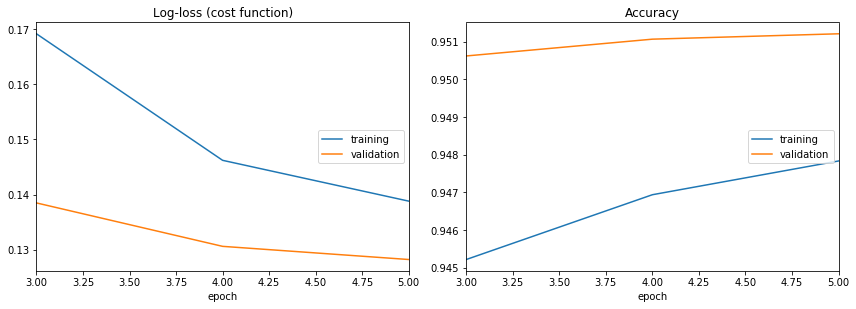

Log-loss (cost function):
training   (min:    0.139, max:    0.536, cur:    0.139)
validation (min:    0.128, max:    0.357, cur:    0.128)

Accuracy:
training   (min:    0.812, max:    0.948, cur:    0.948)
validation (min:    0.940, max:    0.951, cur:    0.951)
Wall time: 10h 22s


In [23]:
%%time
model = build_model2(lr = 1e-4, lr_d = 0, units = 64, spatial_dr = 0.5, kernel_size1=4, kernel_size2=3, dense_units=16, dr=0.1, conv_size=16, epochs=5)

In [24]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

431021/431021 [==============================] - 2205s 5ms/step
Test loss: 0.12459266796889229
Test accuracy: 0.9527122808404213


In [25]:
# Model 3 - different kernel initializer - RandomNormal for Conv1D layers

def build_model3(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, 
                conv_size=32, epochs=20):
    file_path = "best_model.hdf5"
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)

    inp = Input(shape = (max_len,))
    x = Embedding(max_features + 1, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(GRU(units, return_sequences = True))(x1)
    x_lstm = Bidirectional(LSTM(units, return_sequences = True))(x1)
    
    x_conv1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='RandomNormal')(x_gru)
    max_pool1_gru = GlobalMaxPooling1D()(x_conv1)
    
    
    x_conv2 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='RandomNormal')(x_lstm)
    max_pool1_lstm = GlobalMaxPooling1D()(x_conv2)

    
    
    x = concatenate([max_pool1_gru, max_pool1_lstm])
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dense(2, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    model.summary()
    history = model.fit(X_train, y_train, batch_size = 512, epochs = epochs, validation_split=0.1, 
                        verbose = 1, callbacks = [check_point, early_stop, PlotLossesKeras()])
    model = load_model(file_path)
    return model

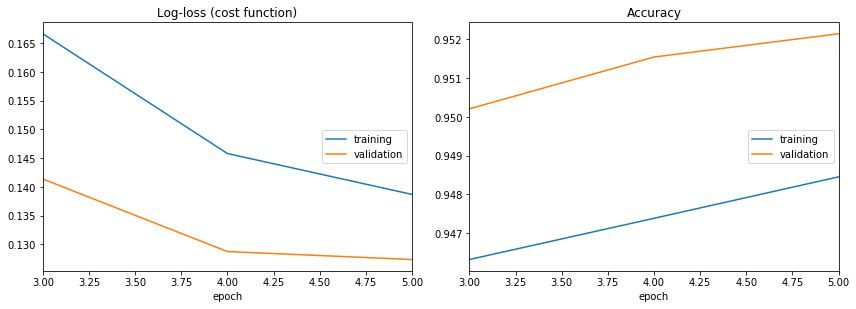

Log-loss (cost function):
training   (min:    0.139, max:    0.546, cur:    0.139)
validation (min:    0.127, max:    0.362, cur:    0.127)

Accuracy:
training   (min:    0.788, max:    0.948, cur:    0.948)
validation (min:    0.934, max:    0.952, cur:    0.952)
Wall time: 11h 4min 48s


In [26]:
%%time
model = build_model3(lr = 1e-4, lr_d = 0, units = 64, spatial_dr = 0.5, kernel_size1=4, kernel_size2=3, dense_units=16, dr=0.1, conv_size=16, epochs=5)

In [27]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

431021/431021 [==============================] - 3367s 8ms/step
Test loss: 0.12350578806582761
Test accuracy: 0.9535475069661562


In [28]:
# no changes in using random normal initalizer 

In [29]:
# Single GRU, Double batchnormalizations. Doulbe dense

def build_model4(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, conv_size=32, epochs=20):
    file_path = "best_model.hdf5"
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)

    inp = Input(shape = (max_len,))
    x = Embedding(max_features + 1, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(GRU(units, return_sequences = True))(x1)
    
    x_conv1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x_conv1)
    max_pool1_gru = GlobalMaxPooling1D()(x_conv1)
    
    x_conv2 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool2_gru = GlobalAveragePooling1D()(x_conv2)
    max_pool2_gru = GlobalMaxPooling1D()(x_conv2)
    
    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool2_gru, max_pool2_gru])
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(2, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    model.summary()
    history = model.fit(X_train, y_train, batch_size = 512, epochs = epochs, validation_split=0.1, 
                        verbose = 1, callbacks = [check_point, early_stop, PlotLossesKeras()])
    model = load_model(file_path)
    return model


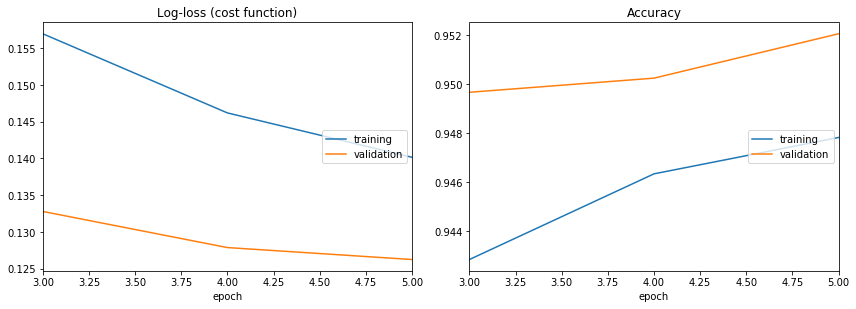

Log-loss (cost function):
training   (min:    0.140, max:    0.282, cur:    0.140)
validation (min:    0.126, max:    0.148, cur:    0.126)

Accuracy:
training   (min:    0.894, max:    0.948, cur:    0.948)
validation (min:    0.946, max:    0.952, cur:    0.952)
Wall time: 9h 14min 32s


In [30]:
%%time
model = build_model4(lr = 1e-4, lr_d = 1e-7, units = 128, spatial_dr = 0.3, kernel_size1=4, kernel_size2=3, dense_units=32, dr=0.3, conv_size=32, epochs=5)

In [31]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

431021/431021 [==============================] - 3066s 7ms/step
Test loss: 0.12390515017195507
Test accuracy: 0.9533154997088309


In [32]:
# Double Bidirectional GRU layers,  Double Batchnormalization, Double Dense

def build_model5(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, conv_size=32, epochs=20):
    file_path = "best_model.hdf5"
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)

    inp = Input(shape = (max_len,))
    x = Embedding(max_features + 1, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(GRU(units * 2, return_sequences = True))(x1)
    x_gru = Bidirectional(GRU(units, return_sequences = True))(x_gru)
    
    x_conv1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x_conv1)
    max_pool1_gru = GlobalMaxPooling1D()(x_conv1)
    
    x_conv2 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool2_gru = GlobalAveragePooling1D()(x_conv2)
    max_pool2_gru = GlobalMaxPooling1D()(x_conv2)
    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool2_gru, max_pool2_gru])
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(2, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    model.summary()
    history = model.fit(X_train, y_train, batch_size = 512, epochs = epochs, validation_split=0.1, 
                        verbose = 1, callbacks = [check_point, early_stop])
    model = load_model(file_path)
    return model

In [33]:
%%time
model = build_model5(lr = 1e-4, lr_d = 1e-7, units = 256, spatial_dr = 0.3, kernel_size1=4, kernel_size2=3, dense_units=32, dr=0.1, conv_size=32, epochs=5)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 70, 300)      27000300    input_5[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_5 (SpatialDro (None, 70, 300)      0           embedding_5[0][0]                
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 70, 1024)     2497536     spatial_dropout1d_5[0][0]        
__________________________________________________________________________________________________
bidirectio

In [36]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

431021/431021 [==============================] - 22879s 53ms/step
Test loss: 0.11734020953069065
Test accuracy: 0.9550532340651615


In [37]:
#Decrease units to 64 and build model 5 again 


model = build_model5(lr = 1e-4, lr_d = 1e-7, units = 64, spatial_dr = 0.3, kernel_size1=4, kernel_size2=3, dense_units=32, dr=0.1, conv_size=8, epochs=5)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 70, 300)      27000300    input_6[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_6 (SpatialDro (None, 70, 300)      0           embedding_6[0][0]                
__________________________________________________________________________________________________
bidirectional_9 (Bidirectional) (None, 70, 256)      329472      spatial_dropout1d_6[0][0]        
__________________________________________________________________________________________________
bidirectio

In [38]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

431021/431021 [==============================] - 9085s 21ms/step
Test loss: 0.12014513911110418
Test accuracy: 0.954277169789871


In [39]:
#One GRU, LSTM, Single Batch

def build_model20(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, 
                conv_size=32, epochs=20):
    file_path = "best_model.hdf5"
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)

    inp = Input(shape = (max_len,))
    x = Embedding(max_features + 1, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(GRU(units, return_sequences = True))(x1)
    x_lstm = Bidirectional(LSTM(units, return_sequences = True))(x1)
    
    x_conv1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x_conv1)
    max_pool1_gru = GlobalMaxPooling1D()(x_conv1)
    
    x_conv2 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool2_gru = GlobalAveragePooling1D()(x_conv2)
    max_pool2_gru = GlobalMaxPooling1D()(x_conv2)
    
    x_conv3 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool1_lstm = GlobalAveragePooling1D()(x_conv3)
    max_pool1_lstm = GlobalMaxPooling1D()(x_conv3)
    
    x_conv4 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool2_lstm = GlobalAveragePooling1D()(x_conv4)
    max_pool2_lstm = GlobalMaxPooling1D()(x_conv4)
    
    
    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool2_gru, max_pool2_gru,
                    avg_pool1_lstm, max_pool1_lstm, avg_pool2_lstm, max_pool2_lstm])
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dense(2, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    model.summary()
    history = model.fit(X_train, y_train, batch_size = 512, epochs = epochs, validation_split=0.1, 
                        verbose = 1, callbacks = [check_point, early_stop, PlotLossesKeras()])
    model = load_model(file_path)
    return model

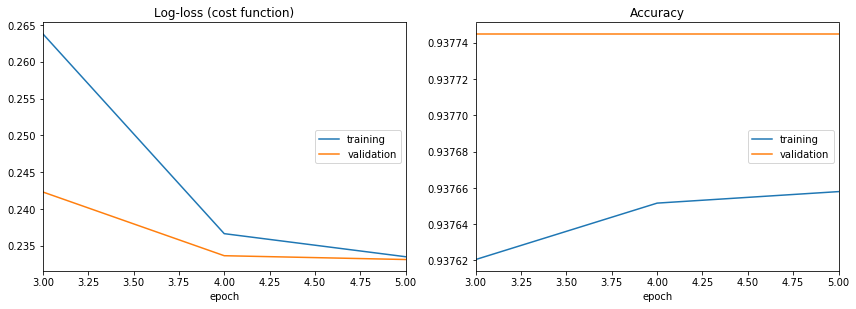

Log-loss (cost function):
training   (min:    0.234, max:    0.602, cur:    0.234)
validation (min:    0.233, max:    0.477, cur:    0.233)

Accuracy:
training   (min:    0.854, max:    0.938, cur:    0.938)
validation (min:    0.938, max:    0.938, cur:    0.938)
Wall time: 23h 5min 14s


In [40]:
%%time
model = build_model20(lr = 1e-4, lr_d = 0, units = 64, spatial_dr = 0.5, kernel_size1=4, kernel_size2=3, dense_units=16, dr=0.1, conv_size=16, epochs=5)

In [41]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

431021/431021 [==============================] - 11383s 26ms/step
Test loss: 0.22964484459516035
Test accuracy: 0.9390354530292473


In [42]:
from keras import backend as K, initializers, regularizers, constraints
from keras.engine.topology import Layer

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
        """
        self.supports_masking = True
        #self.init = initializations.get('glorot_uniform')
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        # eij = K.dot(x, self.W) TF backend doesn't support it

        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())
            
        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
    #print weigthted_input.shape
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        #return input_shape[0], input_shape[-1]
        return input_shape[0],  self.features_dim


In [43]:
def build_model3(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, dense_units=128, dr=0.1, use_attention=True):
    inp = Input(shape = (max_len,))
    x = Embedding(max_features + 1, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(GRU(units * 2, return_sequences = True))(x1)
    if use_attention:
        x_att = Attention(max_len)(x_gru)
        x = Dropout(dr)(Dense(dense_units, activation='relu') (x_att))
    else:
        x_att = Flatten() (x_gru)
        x = Dropout(dr)(Dense(dense_units, activation='relu') (x_att))

    x = BatchNormalization()(x)
    #x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(2, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    #model.summary()
    #history = model.fit(X_train, y_ohe, batch_size = 512, epochs = epochs, validation_split=0.1, 
    #                    verbose = 1, callbacks = [check_point, early_stop])
    #model = load_model(file_path)
    return model

In [44]:
%%time
file_path = "best_model.hdf5"
check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                              save_best_only = True, mode = "min")
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)
model6 = build_model3(lr = 1e-3, lr_d = 1e-7, units = 64, spatial_dr = 0.3, dense_units=16, dr=0.1, use_attention=True)
history = model6.fit(X_train, y_train, batch_size = 512, epochs = 10, validation_split=0.1, 
                    verbose = 1, callbacks = [check_point, early_stop])

Train on 787590 samples, validate on 87511 samples
Epoch 1/10
787590/787590 [==============================] - 9733s 12ms/step - loss: 0.1927 - acc: 0.9290 - val_loss: 0.1254 - val_acc: 0.9528

Epoch 00001: val_loss improved from inf to 0.12538, saving model to best_model.hdf5
Epoch 2/10
787590/787590 [==============================] - 10054s 13ms/step - loss: 0.1249 - acc: 0.9529 - val_loss: 0.1167 - val_acc: 0.9538

Epoch 00002: val_loss improved from 0.12538 to 0.11674, saving model to best_model.hdf5
Epoch 3/10
787590/787590 [==============================] - 30050s 38ms/step - loss: 0.1188 - acc: 0.9548 - val_loss: 0.1170 - val_acc: 0.9521

Epoch 00003: val_loss did not improve from 0.11674
Epoch 4/10
787590/787590 [==============================] - 12250s 16ms/step - loss: 0.1142 - acc: 0.9565 - val_loss: 0.1118 - val_acc: 0.9558

Epoch 00004: val_loss improved from 0.11674 to 0.11183, saving model to best_model.hdf5
Epoch 5/10
787590/787590 [==============================] - 989

In [45]:
def build_model4(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, conv_size=32, epochs=20):
    file_path = "best_model.hdf5"
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)

    inp = Input(shape = (max_len,))
    x = Embedding(max_features + 1, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(GRU(units, return_sequences = True))(x1)
    
    x_conv1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x_conv1)
    max_pool1_gru = GlobalMaxPooling1D()(x_conv1)
       
    x = concatenate([avg_pool1_gru, max_pool1_gru])
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    #x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(2, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    model.summary()
    history = model.fit(X_train, y_train, batch_size = 512, epochs = epochs, validation_split=0.1, 
                        verbose = 1, callbacks = [check_point, early_stop])
    model = load_model(file_path)
    return model

In [46]:
%%time
model7 = build_model4(lr = 1e-4, lr_d = 1e-7, units = 64, spatial_dr = 0.3, kernel_size1=3, dense_units=32, dr=0.1, conv_size=8, epochs=5)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 70, 300)      27000300    input_9[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_9 (SpatialDro (None, 70, 300)      0           embedding_9[0][0]                
__________________________________________________________________________________________________
bidirectional_14 (Bidirectional (None, 70, 128)      140160      spatial_dropout1d_9[0][0]        
__________________________________________________________________________________________________
conv1d_16 